# Restart after installing h5py

In [ ]:
! pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 8.6 MB/s 
     |████████████████████████████████| 15.7 MB 35.7 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.

In [ ]:
!pip install -U scikit-image==0.16.2

     |████████████████████████████████| 26.5 MB 68.1 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Run the code installing keras below twice, it will be installed 2.1.0 **on the secone time only**


In [ ]:
!pip install -U keras==2.1.0

  Using cached Keras-2.1.0-py2.py3-none-any.whl (302 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


# The developed code is working with TF 1.15.2, Skimage 0.16.2 and Keras 2.1.0. Check them carefully

In [ ]:
import tensorflow
import skimage
print(tensorflow.__version__,  skimage.__version__)
import keras
keras.__version__

1.15.2 0.16.2


Using TensorFlow backend.


'2.1.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The code below is only uncomment **when needed**, currently it's from my google drive

In [ ]:
#!cp /content/drive/MyDrive/Colab\ Notebooks/train.zip /content/train.zip 
#!cp /content/drive/MyDrive/Colab\ Notebooks/val.zip /content/val.zip 

#!mkdir /content/mrcnn 
#!cp -rp /content/drive/MyDrive/1_ImplantProject/mrcnn/* /content/mrcnn/

#!mkdir -p /content/dataset/train
#!mkdir -p /content/dataset/val
#!cp -rp /content/drive/MyDrive/1_ImplantProject/dataset/train /content/dataset/train/
#!cp -rp /content/drive/MyDrive/1_ImplantProject/dataset/val /content/dataset/val/
#!unzip /content/train.zip -d /content/dataset/train/
#!unzip /content/val.zip -d /content/dataset/val/

In [ ]:
#Mapping to your location in google drive

import os
os.chdir("/content/drive/MyDrive/1_ImplantProject/")
!pwd

/content/drive/MyDrive/1_ImplantProject


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

print(ROOT_DIR)

/content/drive/MyDrive/1_ImplantProject


# Configurations

In [ ]:
class ImplantConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "implant"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 types of implants

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 500

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50

    # Skip detections with < 70% confidence
    #DETECTION_MIN_CONFIDENCE = 0.7
    
config = ImplantConfig()
#config.display()

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

In [ ]:
import json
class ImplantDataset(utils.Dataset):

    def load_implant(self, dataset_dir, subset):
        """Load a subset of the  dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have three classes to add.
        self.add_class("implant", 1, "bego")
        self.add_class("implant", 2, "bicon")
        self.add_class("implant", 3, "straumann")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "implant.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            objects = [s['region_attributes']['name'] for s in a['regions']]
           # print("objects:", objects)
            name_dict = {"bego": 1, "bicon": 2, "straumann": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
           # print("numids", num_ids)

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "implant",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a implant dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        print("QUITRAN Image ID:", image_id, " image path:", image_info["path"])
       # print(" image source:", image_info["source"], "height: ", image_info["height"], " width: ", image_info["width"])
        if image_info["source"] != "implant":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        num_ids = np.array(num_ids, dtype=np.int32)
        #print("Num_ids :", num_ids)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "implant":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

Loading datasets

In [ ]:

# Training dataset
dataset_train = ImplantDataset()
dataset_train.load_implant("./dataset_maskrcnn/","train")
dataset_train.prepare()

# Validation dataset
dataset_val = ImplantDataset()
dataset_val.load_implant("./dataset_maskrcnn/","val")
dataset_val.prepare()

QUITRAN Image ID: 97  image path: ./dataset_maskrcnn/train/bicon3.jpg


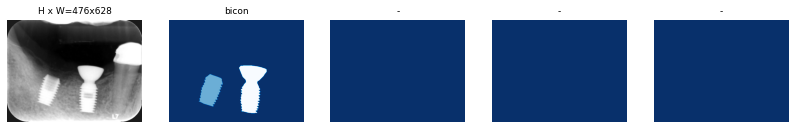

In [ ]:
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Training Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode='training', config=config,model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=200, layers='heads')
#model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1,layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/1_ImplantProject/logs/implant20220515T0318/mask_rcnn_implant_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


QUITRAN Image ID: 74  image path: ./dataset_maskrcnn/train/bicon26.jpg
QUITRAN Image ID: 23  image path: ./dataset_maskrcnn/train/straumann28.jpg
Epoch 1/200
QUITRAN Image ID: 114  image path: ./dataset_maskrcnn/train/bego26.jpg
QUITRAN Image ID: 9  image path: ./dataset_maskrcnn/train/straumann42.jpg
QUITRAN Image ID: 3  image path: ./dataset_maskrcnn/train/straumann48.jpg
QUITRAN Image ID: 131  image path: ./dataset_maskrcnn/train/bego9.jpg
QUITRAN Image ID: 48  image path: ./dataset_maskrcnn/train/straumann3.jpg
QUITRAN Image ID: 107  image path: ./dataset_maskrcnn/train/bego33.jpg
QUITRAN Image ID: 22  image path: ./dataset_maskrcnn/train/straumann29.jpg
QUITRAN Image ID: 7  image path: ./dataset_maskrcnn/train/straumann44.jpg
QUITRAN Image ID: 118  image path: ./dataset_maskrcnn/train/bego22.jpg
QUITRAN Image ID: 38  image path: ./dataset_maskrcnn/train/straumann13.jpg
QUITRAN Image ID: 86  image path: ./dataset_maskrcnn/train/bicon14.jpg
QUITRAN Image ID: 66  image path: ./datase

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


QUITRAN Image ID: 87  image path: ./dataset_maskrcnn/train/bicon13.jpg
QUITRAN Image ID: 2  image path: ./dataset_maskrcnn/train/straumann49.jpg
QUITRAN Image ID: 88  image path: ./dataset_maskrcnn/train/bicon12.jpg
QUITRAN Image ID: 124  image path: ./dataset_maskrcnn/train/bego16.jpg
QUITRAN Image ID: 94  image path: ./dataset_maskrcnn/train/bicon6.jpg
QUITRAN Image ID: 8  image path: ./dataset_maskrcnn/train/straumann43.jpg
QUITRAN Image ID: 127  image path: ./dataset_maskrcnn/train/bego13.jpg
QUITRAN Image ID: 114  image path: ./dataset_maskrcnn/train/bego26.jpg
QUITRAN Image ID: 103  image path: ./dataset_maskrcnn/train/bego37.jpg
QUITRAN Image ID: 24  image path: ./dataset_maskrcnn/train/straumann27.jpg
QUITRAN Image ID: 42  image path: ./dataset_maskrcnn/train/straumann9.jpg
QUITRAN Image ID: 53  image path: ./dataset_maskrcnn/train/bicon47.jpg
QUITRAN Image ID: 1  image path: ./dataset_maskrcnn/train/straumann50.jpg
QUITRAN Image ID: 123  image path: ./dataset_maskrcnn/train/be

KeyboardInterrupt: ignored

# DONE Building Model

Load, test and calculate the confusion matrix will be on other file